This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting readmission using pytorch library.
* The logistic regression model has the architecture of an embedding layer, a linear activation and sigmoid transformation.
* Our model currently achieves around 0.81 test accuracy.
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end.

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random

import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model as model
import Loaddata as Loaddata
import TrainVaTe as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=0.001, help='initial learning rate [default: 0.001]')
parser.add_argument('-L2', type=float, default=0.00001, help='L2 regularization [default: 0.00001]')
parser.add_argument('-epochs', type=int, default=5, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=2, help='number of embedding dimension [default: 2]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = 0.001
args.L2 = 0.00001
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
args.seq_file = 'Data/h143.visits'
args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
# load and prepare data
set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit])  
else: 
    model_x = set_x     
    
merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)


Loading and preparing data...

Sample data after split:
[0, [1667, 144, 62, 85, 1667, 144, 62, 85]]
model is LR


In [6]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

In [7]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep=[]

In [15]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 0.3142301637306855
[0.3094059275084528, 0.29525122769336554, 0.28923936282787666, 0.3236679132899426, 0.3078873898270376, 0.3361786729889045, 0.3218528705708486, 0.32521242868090894, 0.3250397298196516, 0.31273173586636255, 0.3165399051691536, 0.29853826558215313, 0.3221075513135772, 0.3409053946685838, 0.3478340891399967, 0.2890976930616614, 0.3185672976717832, 0.2981800973545552, 0.3298011124187749, 0.3191078552560575, 0.3056832616014999, 0.2872557406854016, 0.3129834237823534, 0.31122103044021543, 0.31692464180130037, 0.33353331899268596, 0.3049301617061419, 0.3100627787198427, 0.3029338697507908] 
 train loss plot


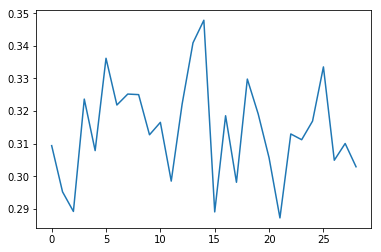


 Current running on: Epoch  0  Training auc: 0.8018810292181758


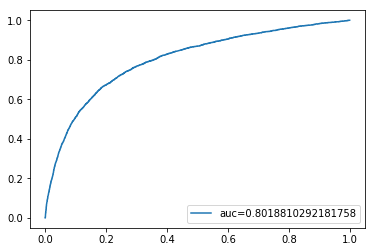


 Current running on: Epoch  0  validation auc: 0.7670638062562052


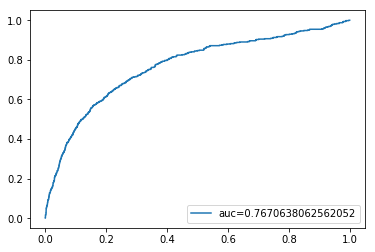


 Current running on: Epoch  0  test auc: 0.8056470357559616


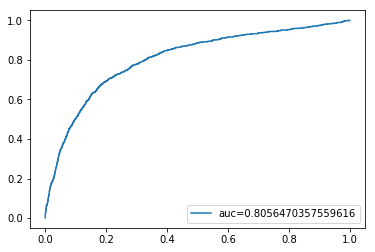

Epoch  0 Summary:  Training_auc : 0.8018810292181758  , Validation_auc :  0.7670638062562052  ,& Test_auc :  0.8056470357559616  Avg Loss:  0.3142301637306855 Train Time (0m 42s) Eval Time (0m 18s)

 Current running on: Epoch  1 Training loss:  Average loss 0.314845699058699
[0.31508388412261956, 0.3073269031707714, 0.2873547540793436, 0.31790591074933855, 0.327986341434982, 0.2866216212069048, 0.30387238634723146, 0.2979600703808856, 0.31467895011143626, 0.3332511120723431, 0.3407572494014987, 0.3055843997658827, 0.29289978335874556, 0.3224532804354678, 0.3039300899871473, 0.3238234632380927, 0.3235279197802533, 0.3110775595210866, 0.32280823593241803, 0.3033995958774554, 0.3286489348514369, 0.33308409258312965, 0.3041638190135732, 0.30620129095643944, 0.34868999240185095, 0.32943664289337177, 0.32812238540879296, 0.3093011977166898, 0.30057340590308196] 
 train loss plot


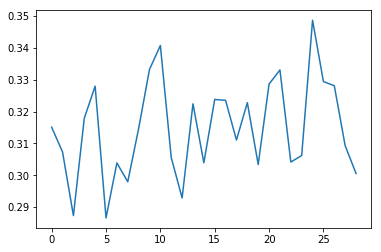


 Current running on: Epoch  1  Training auc: 0.8028962824668923


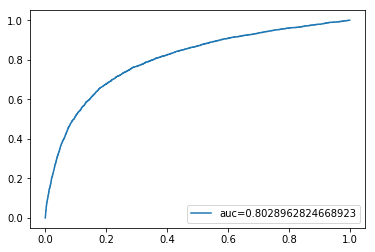


 Current running on: Epoch  1  validation auc: 0.7633852926117719


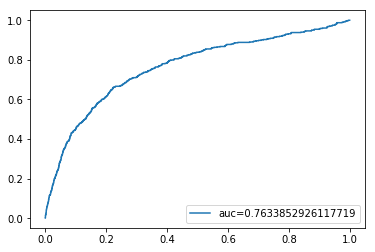


 Current running on: Epoch  1  test auc: 0.8037516279471997


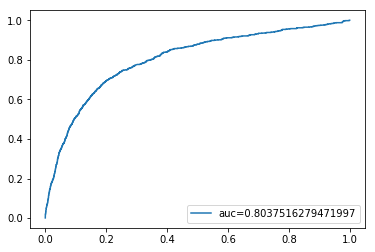

Epoch  1 Summary:  Training_auc : 0.8028962824668923  , Validation_auc :  0.7633852926117719  ,& Test_auc :  0.8037516279471997  Avg Loss:  0.314845699058699 Train Time (0m 43s) Eval Time (0m 18s)

 Current running on: Epoch  2 Training loss:  Average loss 0.3161684941707639
[0.2936291149292583, 0.3046223698936051, 0.31450341435592144, 0.2906529654473043, 0.2985139166877633, 0.3210079564648904, 0.2964837485849189, 0.3716119084991735, 0.3447731119571108, 0.3113652803501463, 0.27690506682077826, 0.3157916187477281, 0.32316224939191013, 0.29915575446230463, 0.30637163701982356, 0.31199504327939703, 0.3530768516937337, 0.33777925677053683, 0.32115001103439406, 0.28457244102708273, 0.32723066761980363, 0.3525132463465852, 0.2955228952791357, 0.2895153804764993, 0.3487405551008942, 0.34195467759157055, 0.304799250934201, 0.30910954006739494, 0.3223764001182883] 
 train loss plot


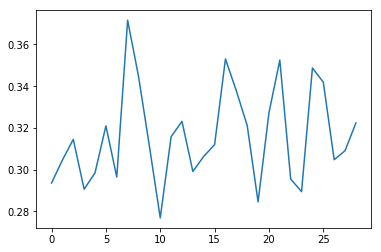


 Current running on: Epoch  2  Training auc: 0.7993153118390555


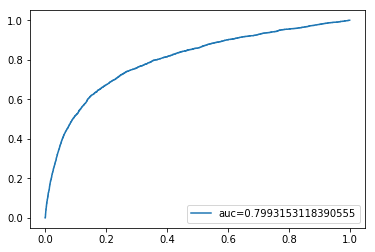


 Current running on: Epoch  2  validation auc: 0.7518798286638831


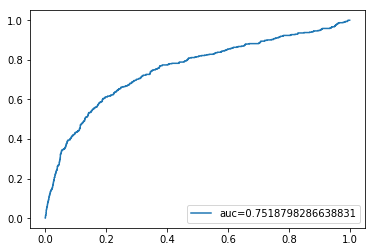


 Current running on: Epoch  2  test auc: 0.7955214013358617


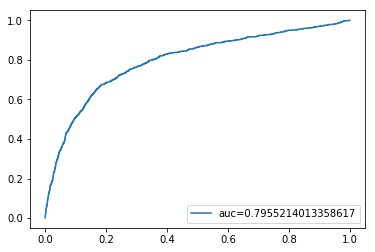

Epoch  2 Summary:  Training_auc : 0.7993153118390555  , Validation_auc :  0.7518798286638831  ,& Test_auc :  0.7955214013358617  Avg Loss:  0.3161684941707639 Train Time (0m 41s) Eval Time (0m 17s)

 Current running on: Epoch  3 Training loss:  Average loss 0.31376567331171523
[0.3120848219607906, 0.30977420382981724, 0.30930840549889693, 0.31318285900891657, 0.2857171645120388, 0.3110975283862664, 0.3157248800935877, 0.3092904827391976, 0.3133232315842743, 0.3106067687515601, 0.3060464084210766, 0.3209792781479442, 0.2881330109694118, 0.33167569228977206, 0.31333116773862274, 0.31856007304742523, 0.34338076583471777, 0.35405881296857844, 0.34650228292257723, 0.34283741808579, 0.30102006597339837, 0.3240152388383724, 0.26748090341786257, 0.32466536719985495, 0.3062097797592252, 0.305881967224636, 0.30931413538708036, 0.30566772441831996, 0.29933408702972836] 
 train loss plot


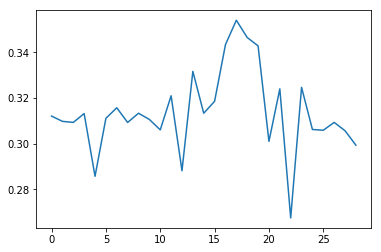


 Current running on: Epoch  3  Training auc: 0.8012674055303338


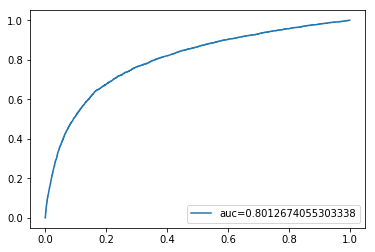


 Current running on: Epoch  3  validation auc: 0.7583541110340657


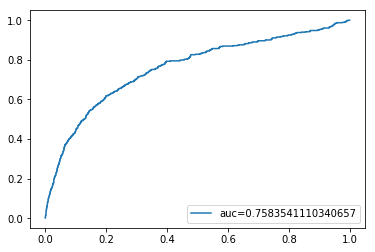


 Current running on: Epoch  3  test auc: 0.8013624990039914


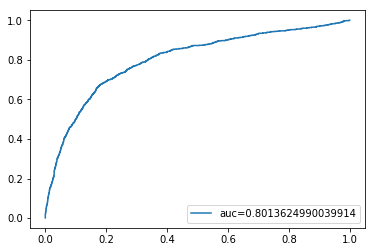

Epoch  3 Summary:  Training_auc : 0.8012674055303338  , Validation_auc :  0.7583541110340657  ,& Test_auc :  0.8013624990039914  Avg Loss:  0.31376567331171523 Train Time (0m 43s) Eval Time (0m 18s)

 Current running on: Epoch  4 Training loss:  Average loss 0.31233257238501944
[0.3084307774555966, 0.3208106069476669, 0.29761636760286797, 0.34887696583999966, 0.32128270400503245, 0.2786752133027389, 0.3332231753397427, 0.3218818498758236, 0.264941885932005, 0.31443551646835827, 0.33608958862888383, 0.32524162309262467, 0.30946164279001825, 0.3385173632164224, 0.34961410593077913, 0.31085391730776973, 0.31317981878582213, 0.3197822540152195, 0.2872182183201303, 0.3047642445489137, 0.3178469222855556, 0.3013390763035659, 0.2908265656678132, 0.3320825173756575, 0.2958664766421514, 0.2842659858042771, 0.3018775745768966, 0.31581922730324913, 0.3128224137999798] 
 train loss plot


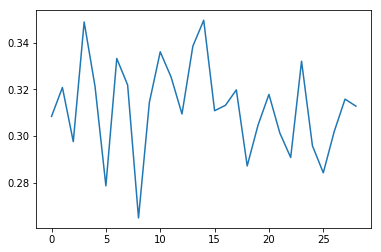


 Current running on: Epoch  4  Training auc: 0.8061428703308049


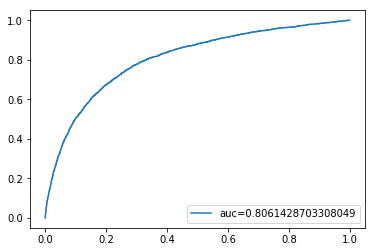


 Current running on: Epoch  4  validation auc: 0.7699950876652312


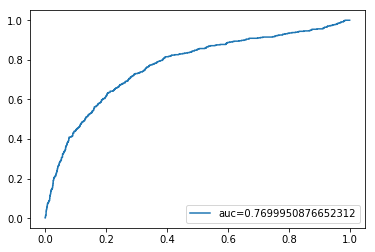


 Current running on: Epoch  4  test auc: 0.8028807152878417


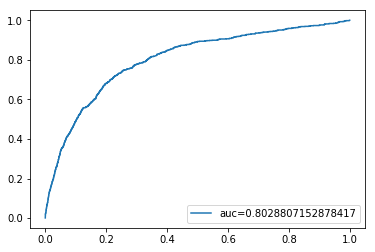

Epoch  4 Summary:  Training_auc : 0.8061428703308049  , Validation_auc :  0.7699950876652312  ,& Test_auc :  0.8028807152878417  Avg Loss:  0.31233257238501944 Train Time (0m 39s) Eval Time (0m 19s)

 Current running on: Epoch  5 Training loss:  Average loss 0.31291869824744034
[0.346454531720865, 0.26609971985132497, 0.3104290492279579, 0.2959019456252754, 0.34915352149763396, 0.3013033467542191, 0.3234481106157036, 0.32924230804041876, 0.3244052479571992, 0.27801716220933487, 0.27425462664664246, 0.34521152872730454, 0.3253232231028658, 0.302998499952002, 0.28427292592187586, 0.2950838569990078, 0.31979214122940175, 0.3315760833695358, 0.3349956084137891, 0.3009964706809297, 0.3557132610779235, 0.2933697066466757, 0.33214837971479133, 0.29164026790374964, 0.32470691485141107, 0.3068089891120757, 0.2948222983739147, 0.33656753775786685, 0.299904985194073] 
 train loss plot


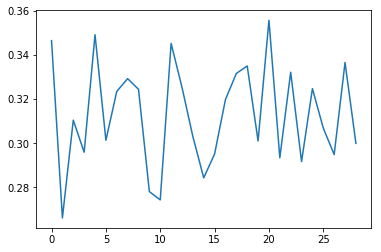


 Current running on: Epoch  5  Training auc: 0.8025933757919811


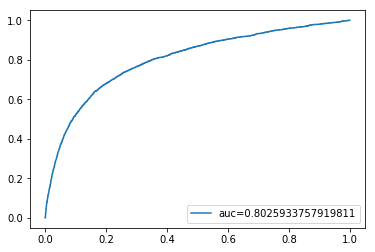


 Current running on: Epoch  5  validation auc: 0.7555556101977666


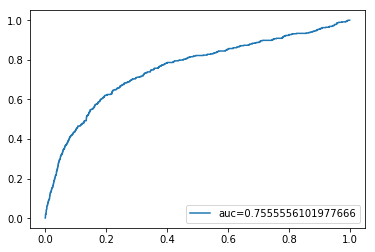


 Current running on: Epoch  5  test auc: 0.7973675186155031


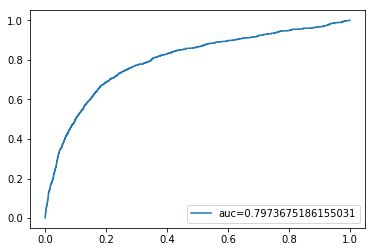

Epoch  5 Summary:  Training_auc : 0.8025933757919811  , Validation_auc :  0.7555556101977666  ,& Test_auc :  0.7973675186155031  Avg Loss:  0.31291869824744034 Train Time (0m 42s) Eval Time (0m 19s)

 Current running on: Epoch  6 Training loss:  Average loss 0.31253912726317207
[0.3116185116352208, 0.34119309725876973, 0.33061474697849963, 0.2869572594343762, 0.29463501871551506, 0.3134151195941772, 0.322799073943853, 0.32035751543237073, 0.30178369491470947, 0.3048537237534238, 0.35686990884773, 0.2997704414770269, 0.299027511207345, 0.326118886077445, 0.3122062319125288, 0.3102713769884927, 0.30930220036873174, 0.3272090291398473, 0.299056474308429, 0.2739964514334682, 0.2867759087981425, 0.3001236793684009, 0.3137646871705125, 0.2982037926281901, 0.309296105149332, 0.32359829805406604, 0.29792662174605244, 0.3361007260629982, 0.355788598232336] 
 train loss plot


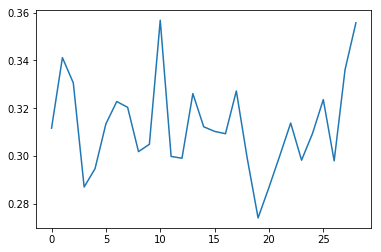


 Current running on: Epoch  6  Training auc: 0.8044014903832117


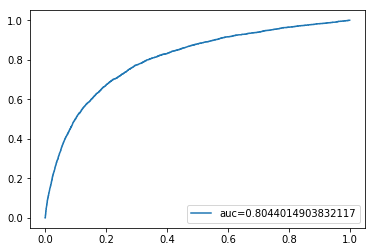


 Current running on: Epoch  6  validation auc: 0.7637710666214229


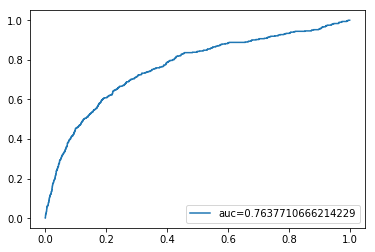


 Current running on: Epoch  6  test auc: 0.8079391473404736


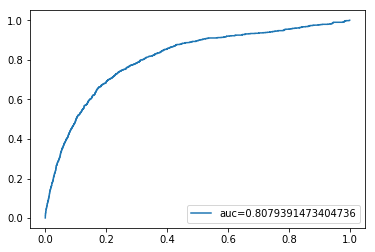

Epoch  6 Summary:  Training_auc : 0.8044014903832117  , Validation_auc :  0.7637710666214229  ,& Test_auc :  0.8079391473404736  Avg Loss:  0.31253912726317207 Train Time (0m 40s) Eval Time (0m 19s)

 Current running on: Epoch  7 Training loss:  Average loss 0.31245406916496005
[0.3577682938540529, 0.28251358150684336, 0.32373153323301396, 0.3075423032778818, 0.28467649735518763, 0.3030451033667002, 0.2966221048925413, 0.2634909177080549, 0.3221846546090219, 0.3319010271921538, 0.29208429997586716, 0.2786056019270545, 0.299789820579143, 0.31749818796541285, 0.31152146793662494, 0.35174052047501037, 0.3412279598635471, 0.33762417905401915, 0.2974350415735717, 0.30658067106135783, 0.3364062986833924, 0.31759096568813855, 0.28018667461183305, 0.3044803963054396, 0.30226244347237663, 0.29668664419910057, 0.3074387280698211, 0.3518787770608658, 0.35665331028581315] 
 train loss plot


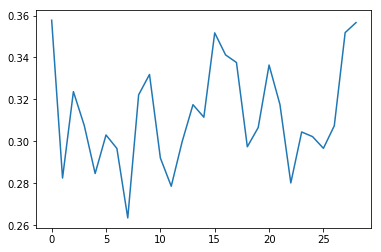


 Current running on: Epoch  7  Training auc: 0.8064318955169685


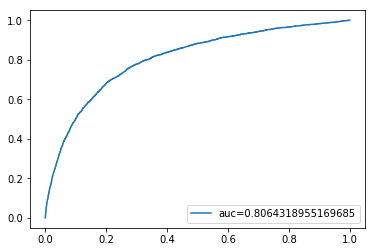


 Current running on: Epoch  7  validation auc: 0.7695696980526062


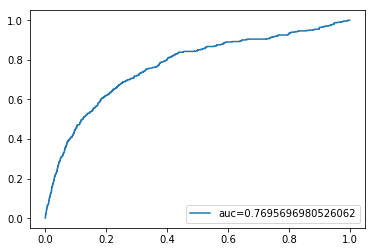


 Current running on: Epoch  7  test auc: 0.8093381825242569


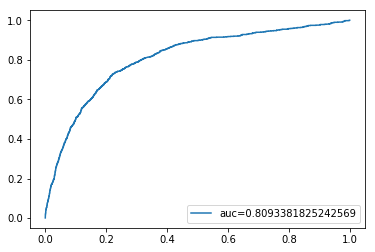

Epoch  7 Summary:  Training_auc : 0.8064318955169685  , Validation_auc :  0.7695696980526062  ,& Test_auc :  0.8093381825242569  Avg Loss:  0.31245406916496005 Train Time (0m 41s) Eval Time (0m 19s)

 Current running on: Epoch  8 Training loss:  Average loss 0.31483157113234017
[0.2960001440085034, 0.32296780042079554, 0.2905032648188246, 0.2853387075813889, 0.31615446795916796, 0.30897316212025416, 0.3233360077851254, 0.3235254291587045, 0.298484272114174, 0.2899018939011879, 0.30821466242779844, 0.319410151010979, 0.3036809085275163, 0.3229661690260691, 0.2860983587631462, 0.37237721913879807, 0.32054079293944776, 0.3076853998995243, 0.3119450515340129, 0.33999698001558976, 0.32073587043368773, 0.31580481007137495, 0.2928472834987979, 0.35567171672473613, 0.32887905650518223, 0.34036587840605353, 0.30880897409061797, 0.3099725598821065, 0.30892857007429847] 
 train loss plot


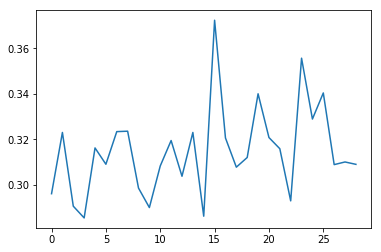


 Current running on: Epoch  8  Training auc: 0.8017254199699844


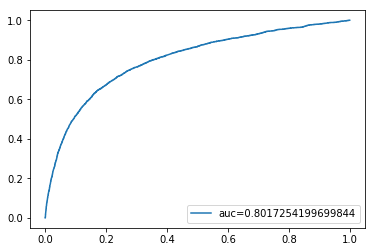


 Current running on: Epoch  8  validation auc: 0.7590909612493832


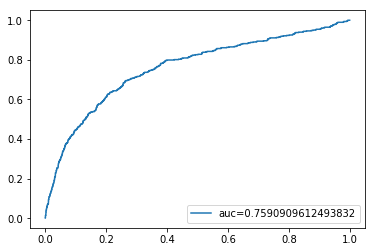


 Current running on: Epoch  8  test auc: 0.8018132523944319


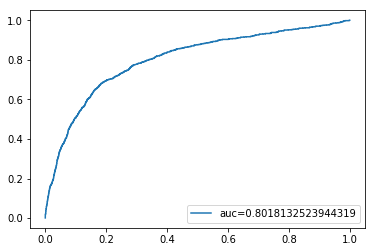

Epoch  8 Summary:  Training_auc : 0.8017254199699844  , Validation_auc :  0.7590909612493832  ,& Test_auc :  0.8018132523944319  Avg Loss:  0.31483157113234017 Train Time (0m 42s) Eval Time (0m 19s)

 Current running on: Epoch  9 Training loss:  Average loss 0.31324941882045465
[0.2808713658555811, 0.33709196492502824, 0.2984654906767864, 0.31519768092413875, 0.3085354359993176, 0.3115865517971881, 0.31121445996551866, 0.3195084055486241, 0.33826708432898317, 0.3333069796206228, 0.3036570135041852, 0.3075797732203282, 0.31644042506556114, 0.32430305525193903, 0.292270600754479, 0.3086227066397605, 0.2982881828087466, 0.35537785222570256, 0.2967330366017577, 0.3224793309328629, 0.32684338175255473, 0.310061414495039, 0.3053236119425898, 0.3412505191231667, 0.2922033671421232, 0.29516542572759136, 0.3110159278091778, 0.28080080936504076, 0.3417712917887907] 
 train loss plot


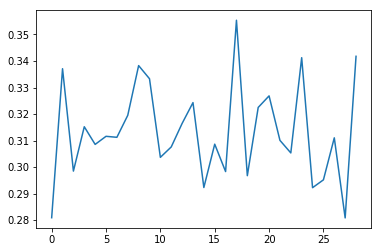


 Current running on: Epoch  9  Training auc: 0.8045364747907042


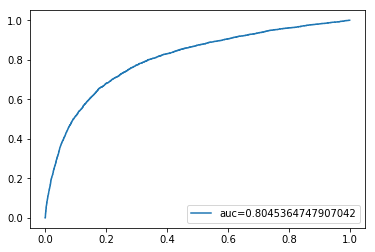


 Current running on: Epoch  9  validation auc: 0.7634792772146899


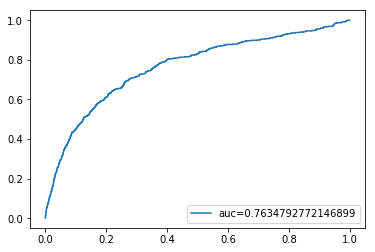


 Current running on: Epoch  9  test auc: 0.803706484621219


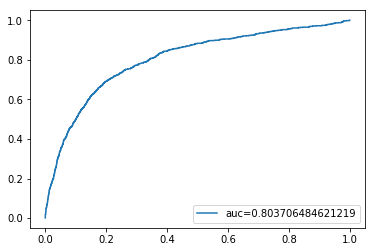

Epoch  9 Summary:  Training_auc : 0.8045364747907042  , Validation_auc :  0.7634792772146899  ,& Test_auc :  0.803706484621219  Avg Loss:  0.31324941882045465 Train Time (0m 42s) Eval Time (0m 19s)

 Current running on: Epoch  10 Training loss:  Average loss 0.3131179566007035
[0.33209423440896946, 0.33270797886709624, 0.30155092263880945, 0.3256050998659812, 0.26659696494053636, 0.3078695772836198, 0.31708074838173006, 0.31310491796928025, 0.2850334566843412, 0.308960013224376, 0.2858667500997438, 0.35787705112481216, 0.287371392041543, 0.354263102850222, 0.3459647230962646, 0.3187543726828385, 0.2699347816483046, 0.3466787976718963, 0.3277692765539784, 0.2688645242185272, 0.3286532740327421, 0.3214566820542568, 0.2887954883616258, 0.3079907562146809, 0.2774511176448709, 0.3288764419831152, 0.33261826332552574, 0.31685538297270044, 0.3237746485780126] 
 train loss plot


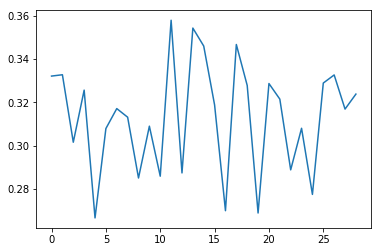


 Current running on: Epoch  10  Training auc: 0.8067648431846307


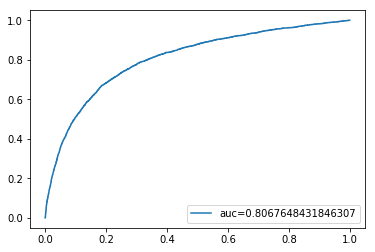


 Current running on: Epoch  10  validation auc: 0.7669638110100777


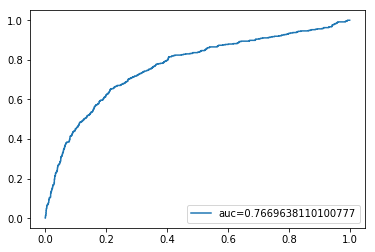


 Current running on: Epoch  10  test auc: 0.8057326313092896


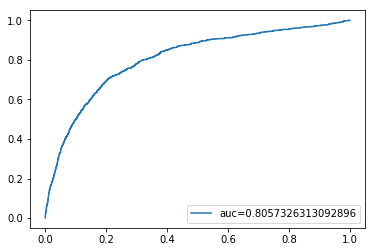

Epoch  10 Summary:  Training_auc : 0.8067648431846307  , Validation_auc :  0.7669638110100777  ,& Test_auc :  0.8057326313092896  Avg Loss:  0.3131179566007035 Train Time (0m 42s) Eval Time (0m 19s)

 Current running on: Epoch  11 Training loss:  Average loss 0.31265949167865015
[0.33937271035466254, 0.32391547493499, 0.32475600089761747, 0.3191131988940888, 0.29355812227339617, 0.3312308460228021, 0.30719227555429823, 0.28412080673058565, 0.32760859366100886, 0.3016447324500814, 0.3284181174833393, 0.29886561225956454, 0.33788105740801805, 0.3269624880422221, 0.27578444525338636, 0.29070095585512173, 0.3218076320968589, 0.29923691058555096, 0.3026025204938487, 0.3097859685285099, 0.30545207928488843, 0.31710270138697466, 0.33987959194707945, 0.2975423127346803, 0.3041238137965577, 0.3046780294840432, 0.3193744052371835, 0.3403634165864397, 0.29405043844305534] 
 train loss plot


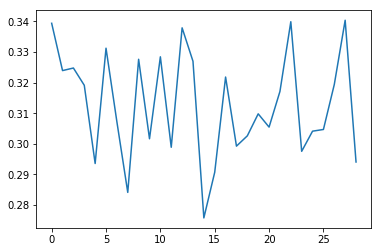


 Current running on: Epoch  11  Training auc: 0.805161387191148


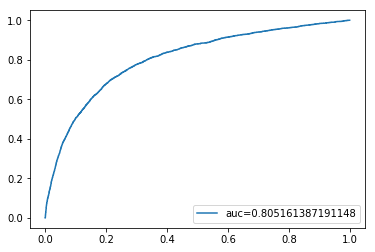


 Current running on: Epoch  11  validation auc: 0.7727643549186459


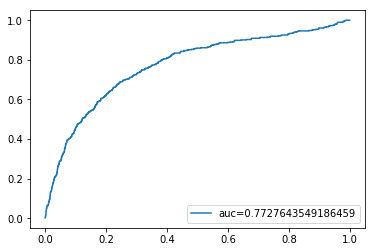


 Current running on: Epoch  11  test auc: 0.8051027323405973


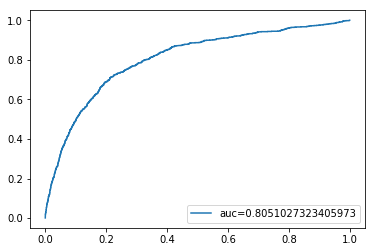

Epoch  11 Summary:  Training_auc : 0.805161387191148  , Validation_auc :  0.7727643549186459  ,& Test_auc :  0.8051027323405973  Avg Loss:  0.31265949167865015 Train Time (0m 42s) Eval Time (0m 15s)

 Current running on: Epoch  12 Training loss:  Average loss 0.3130409701122405
[0.28336309233391205, 0.2911644989750804, 0.31911347204520757, 0.3211606426541696, 0.3406691486849345, 0.3111945718209989, 0.26683789273239855, 0.2932176169340832, 0.31452583031091036, 0.3047228104012574, 0.3292007421040857, 0.3585535637542089, 0.2881275569514946, 0.32481212274912674, 0.3167482731981291, 0.3021447671061046, 0.343688368514829, 0.29436285010238883, 0.3193267541450177, 0.31273998178544943, 0.34666174539984057, 0.27523797033864944, 0.3553642771569945, 0.3377801035143202, 0.31947376339226347, 0.29446822457642063, 0.2721637986584815, 0.32134502091045897, 0.32001867200376044] 
 train loss plot


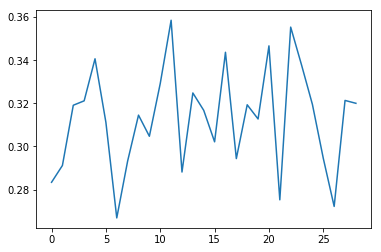


 Current running on: Epoch  12  Training auc: 0.8051851222962361


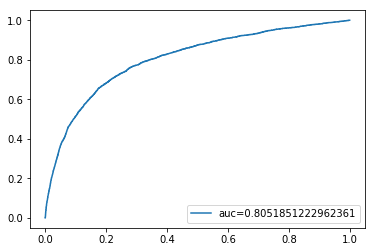


 Current running on: Epoch  12  validation auc: 0.7621301610251315


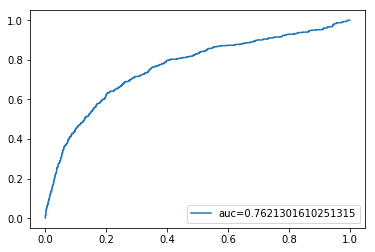


 Current running on: Epoch  12  test auc: 0.8025906150288659


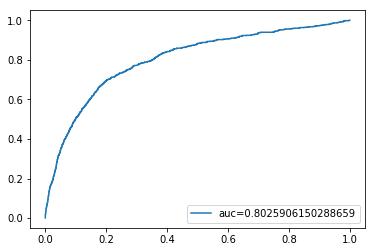

Epoch  12 Summary:  Training_auc : 0.8051851222962361  , Validation_auc :  0.7621301610251315  ,& Test_auc :  0.8025906150288659  Avg Loss:  0.3130409701122405 Train Time (0m 37s) Eval Time (0m 15s)

 Current running on: Epoch  13 Training loss:  Average loss 0.3140366689272077
[0.3028855435790883, 0.31987600123406446, 0.3132118722046271, 0.33032759463693856, 0.35490609293307906, 0.28589046760562015, 0.2967991033993794, 0.2825543177166546, 0.32691821062985266, 0.3296235291585763, 0.3153426418776726, 0.30552757120423785, 0.3261850888762385, 0.3630462873669876, 0.31172086126531523, 0.29136016128421127, 0.33060913984172763, 0.2889341298174593, 0.3322339129305619, 0.3189945490750575, 0.28687723941080184, 0.2808915700738094, 0.31133272393749395, 0.29833613039494294, 0.346450637023132, 0.33550552604292916, 0.3018139791222211, 0.28792972358521507, 0.33097879266112795] 
 train loss plot


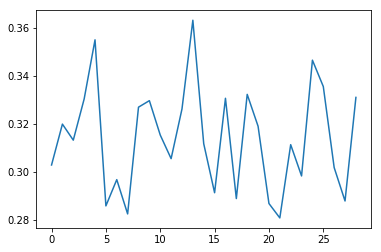


 Current running on: Epoch  13  Training auc: 0.8039279406264079


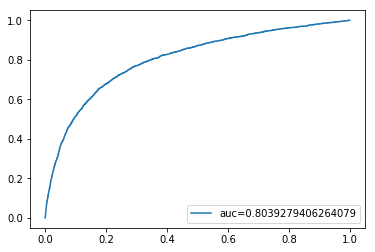


 Current running on: Epoch  13  validation auc: 0.7602788829164953


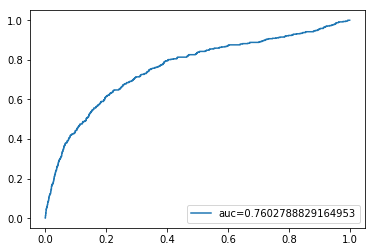


 Current running on: Epoch  13  test auc: 0.8023146560527274


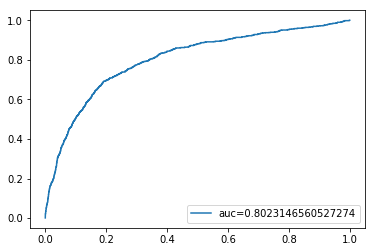

Epoch  13 Summary:  Training_auc : 0.8039279406264079  , Validation_auc :  0.7602788829164953  ,& Test_auc :  0.8023146560527274  Avg Loss:  0.3140366689272077 Train Time (0m 36s) Eval Time (0m 15s)

 Current running on: Epoch  14 Training loss:  Average loss 0.3144555847715787
[0.30745998187224133, 0.3339759381063832, 0.3229827489098443, 0.3181668063594014, 0.3296699502958654, 0.31731835916817364, 0.33630076612241827, 0.3149596172328729, 0.33976321586185165, 0.3133731380183108, 0.3157999504968384, 0.323786443543529, 0.30452614143900064, 0.2811873669194472, 0.3316002892789571, 0.27416684396256186, 0.3063373458422248, 0.3232714895806466, 0.2725752424484426, 0.27424769063865256, 0.33116019583302275, 0.33386731707637407, 0.2849812582590026, 0.33524099510402267, 0.3176311027704628, 0.30945940857038656, 0.33787269642671347, 0.30032669492890274, 0.3272029633092335] 
 train loss plot


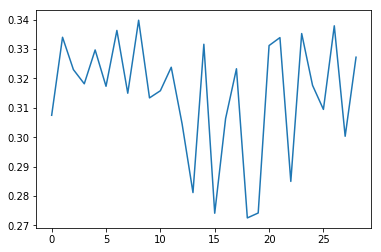


 Current running on: Epoch  14  Training auc: 0.8058152682633445


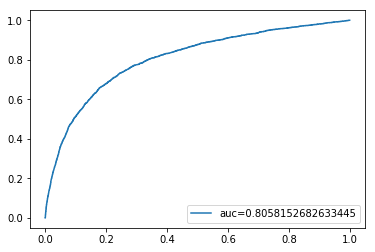


 Current running on: Epoch  14  validation auc: 0.7627192040596977


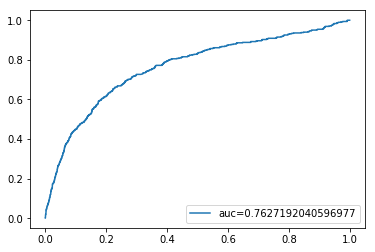


 Current running on: Epoch  14  test auc: 0.8047113995328481


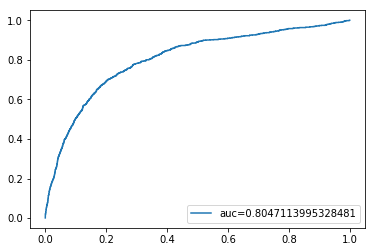

Epoch  14 Summary:  Training_auc : 0.8058152682633445  , Validation_auc :  0.7627192040596977  ,& Test_auc :  0.8047113995328481  Avg Loss:  0.3144555847715787 Train Time (0m 36s) Eval Time (0m 15s)

 Current running on: Epoch  15 Training loss:  Average loss 0.31354068029869925
[0.32035813551350384, 0.29177992246882334, 0.3286993693621953, 0.31363834447785394, 0.33477744781802177, 0.3270452865769048, 0.2979071270558693, 0.3388084346805299, 0.3002057675408981, 0.3008989865662061, 0.3264420704700451, 0.3518389767761987, 0.3240138709983148, 0.3162902177961896, 0.31727121694560634, 0.3148739443296226, 0.30667472695002884, 0.31492179182713426, 0.26267980700555665, 0.2800615533477077, 0.343869500004891, 0.2812721037807505, 0.3090256057207544, 0.3196522432047641, 0.30378596783016804, 0.3173740309103385, 0.30800326211441376, 0.3317578296732882, 0.3087521869156967] 
 train loss plot


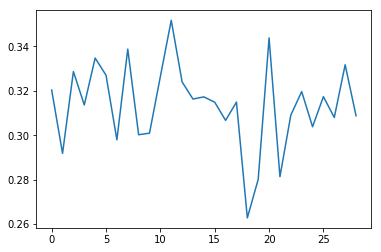


 Current running on: Epoch  15  Training auc: 0.8051265821056023


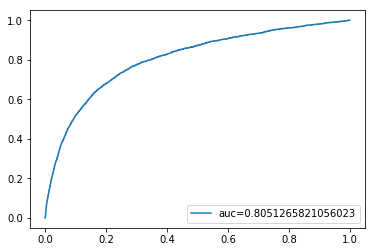


 Current running on: Epoch  15  validation auc: 0.7646163816255731


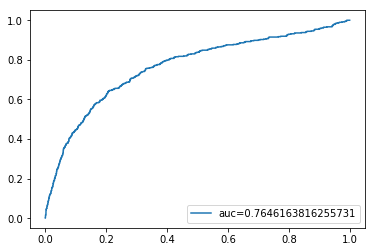


 Current running on: Epoch  15  test auc: 0.8031745548283371


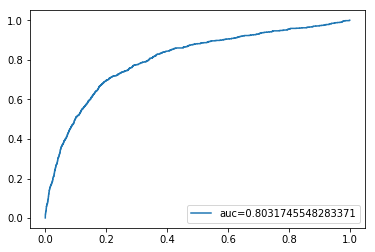

Epoch  15 Summary:  Training_auc : 0.8051265821056023  , Validation_auc :  0.7646163816255731  ,& Test_auc :  0.8031745548283371  Avg Loss:  0.31354068029869925 Train Time (0m 36s) Eval Time (0m 15s)

 Current running on: Epoch  16 Training loss:  Average loss 0.3125517609924492
[0.30556998900928767, 0.3351014685375767, 0.27292495186737936, 0.3132362166336792, 0.2999008695693404, 0.3348149792590138, 0.3451553115982752, 0.2961386599843928, 0.31920811355257045, 0.30876686156413397, 0.2720894037216226, 0.30597737356125826, 0.33895912421031354, 0.2991119118674456, 0.30668263313044397, 0.29855405302278065, 0.3350043755646775, 0.31514388929539566, 0.3337340400004905, 0.3202667452995156, 0.3477536095842581, 0.3011316723619422, 0.30892064152692, 0.35792423602384227, 0.2884209898416975, 0.2989142730173667, 0.3239363860381154, 0.3027471339092563, 0.27791115522803467] 
 train loss plot


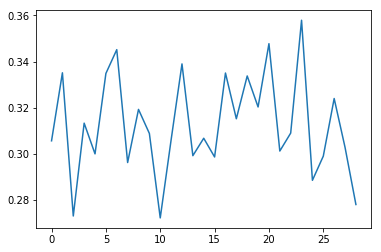


 Current running on: Epoch  16  Training auc: 0.8070016233979631


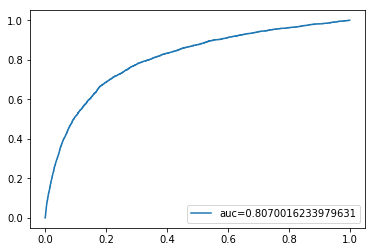


 Current running on: Epoch  16  validation auc: 0.7634880199684495


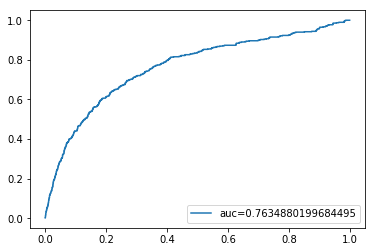


 Current running on: Epoch  16  test auc: 0.8035665675054532


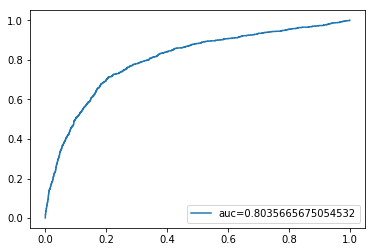

Epoch  16 Summary:  Training_auc : 0.8070016233979631  , Validation_auc :  0.7634880199684495  ,& Test_auc :  0.8035665675054532  Avg Loss:  0.3125517609924492 Train Time (0m 35s) Eval Time (0m 15s)

 Current running on: Epoch  17 Training loss:  Average loss 0.3130427859334388
[0.30498462789049247, 0.310890031560771, 0.3047255043272888, 0.2991411678799966, 0.3169182589519016, 0.29688662749046446, 0.2979608876481668, 0.29751724055085016, 0.3034559512657885, 0.2981731371904, 0.3479924404292478, 0.3122507723626095, 0.2973921593464438, 0.3243170098826813, 0.3178250573982648, 0.2953020517990808, 0.3297731767797444, 0.337030468934339, 0.30606975421024435, 0.27894582289467335, 0.3161030340554062, 0.3600186697903741, 0.3300208621252614, 0.30156144884800234, 0.3072317012111657, 0.32550254315431154, 0.3005924576510497, 0.30368013860688553, 0.3559777878338202] 
 train loss plot


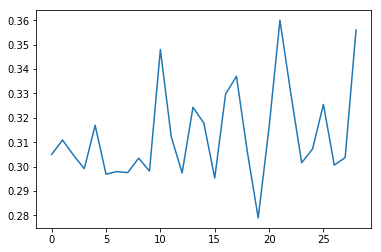


 Current running on: Epoch  17  Training auc: 0.8069033006317752


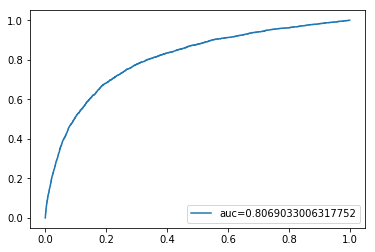


 Current running on: Epoch  17  validation auc: 0.7674840048587853


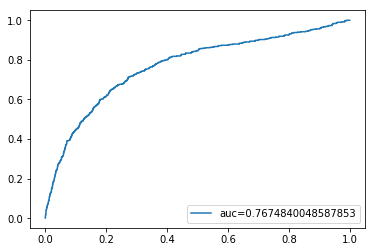


 Current running on: Epoch  17  test auc: 0.8066985217192427


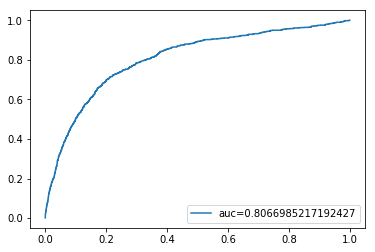

Epoch  17 Summary:  Training_auc : 0.8069033006317752  , Validation_auc :  0.7674840048587853  ,& Test_auc :  0.8066985217192427  Avg Loss:  0.3130427859334388 Train Time (0m 35s) Eval Time (0m 15s)

 Current running on: Epoch  18 Training loss:  Average loss 0.3120428429775078
[0.3173672044567023, 0.2858230329409979, 0.3093662682625808, 0.3083289686313856, 0.30425568751775106, 0.28143483447107387, 0.32974418220025176, 0.3489511006856408, 0.2921125342040841, 0.2905771867395506, 0.30517419412712543, 0.30845351771321194, 0.37493445685706683, 0.27332333032103, 0.33378457394021827, 0.32887339827857615, 0.30534202236867897, 0.3124973768886286, 0.2844734824740987, 0.3559169804516514, 0.33074456924341666, 0.33830944726033346, 0.3029899177338648, 0.3182992125253331, 0.2949821778888486, 0.29362530584740487, 0.2985388674553762, 0.32218321053609145, 0.29883540432675315] 
 train loss plot


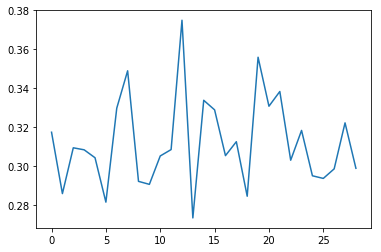


 Current running on: Epoch  18  Training auc: 0.8047334190791791


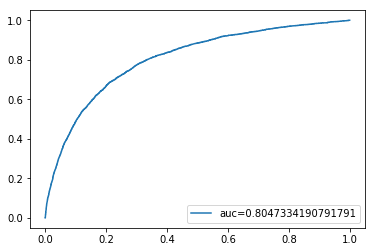


 Current running on: Epoch  18  validation auc: 0.7688183676513739


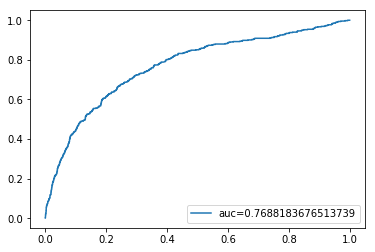


 Current running on: Epoch  18  test auc: 0.8080165844613951


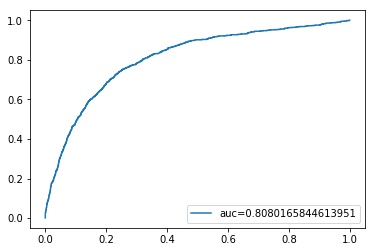

Epoch  18 Summary:  Training_auc : 0.8047334190791791  , Validation_auc :  0.7688183676513739  ,& Test_auc :  0.8080165844613951  Avg Loss:  0.3120428429775078 Train Time (0m 38s) Eval Time (0m 15s)

 Current running on: Epoch  19 Training loss:  Average loss 0.3121804242153403
[0.3081160794510057, 0.31423219494962473, 0.3320230934608744, 0.3271288968307254, 0.3176327464246374, 0.2834815761247496, 0.3167750585821425, 0.308689637958694, 0.3178791152688864, 0.31041509156111713, 0.346263676324367, 0.27264334943165525, 0.2959261558148365, 0.30909256520601075, 0.3553757866814285, 0.3020163346557307, 0.2938138822229694, 0.29228039457905436, 0.3470576199179399, 0.32445224124719424, 0.3136176121750686, 0.3176685818446381, 0.306440582272503, 0.26156113635827705, 0.3046641468982807, 0.3290709677987852, 0.30205420388243703, 0.34267355399826194, 0.3001860203229738] 
 train loss plot


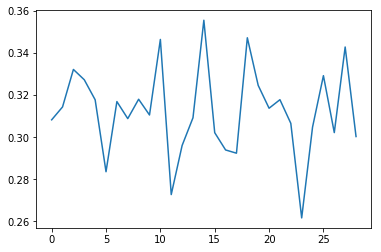


 Current running on: Epoch  19  Training auc: 0.8028545633116243


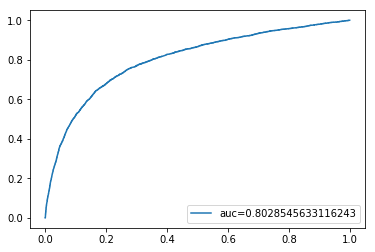


 Current running on: Epoch  19  validation auc: 0.7598701591782249


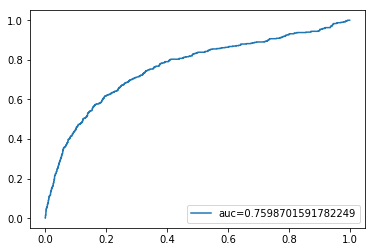


 Current running on: Epoch  19  test auc: 0.8000514389163209


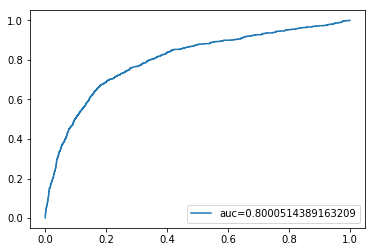

Epoch  19 Summary:  Training_auc : 0.8028545633116243  , Validation_auc :  0.7598701591782249  ,& Test_auc :  0.8000514389163209  Avg Loss:  0.3121804242153403 Train Time (0m 33s) Eval Time (0m 17s)


In [16]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    TVT.auc_plot(y_real, y_hat)
    valid_auc, y_real, y_hat  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    TVT.auc_plot(y_real, y_hat)
    test_auc, y_real, y_hat = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,& Test_auc : " , test_auc, " Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)

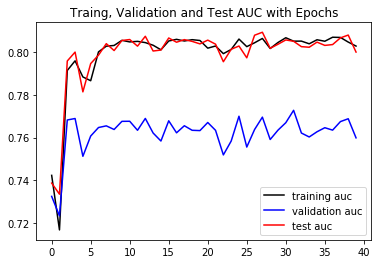

In [18]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label = 'test auc')
plt.title('Traing, Validation and Test AUC with Epochs' )
#plt.xtickes(np.arange(epoches))
plt.legend(loc= 'lower right')
plt.show()

In [14]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg,valid_auc_fg, test_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_dim128')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~GinnyJZ/0 or inside your plot.ly account where it is named 'LR_Auc'
